In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os
from tensorflow import keras
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
#from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
normal_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/normal',224))
osteoarthritis_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/osteoarthritis',224))
normal_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/normal',224))
osteoarthritis_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/osteoarthritis',224))

100%|██████████| 276/276 [00:01<00:00, 259.23it/s]


In [ ]:
print(len(normal_train))
print(len(osteoarthritis_train))
print(len(normal_test))
print(len(osteoarthritis_test))

1020
1971
569
276


In [ ]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
osteoarthritis_train_label = np.ones(len(osteoarthritis_train))
normal_test_label = np.zeros(len(normal_test))
osteoarthritis_test_label = np.ones(len(osteoarthritis_test))

In [ ]:
# Merge data
X_train = np.concatenate((normal_train, osteoarthritis_train), axis = 0)
Y_train = np.concatenate((normal_train_label, osteoarthritis_train_label), axis = 0)
X_test = np.concatenate((normal_test, osteoarthritis_test), axis = 0)
Y_test = np.concatenate((normal_test_label, osteoarthritis_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

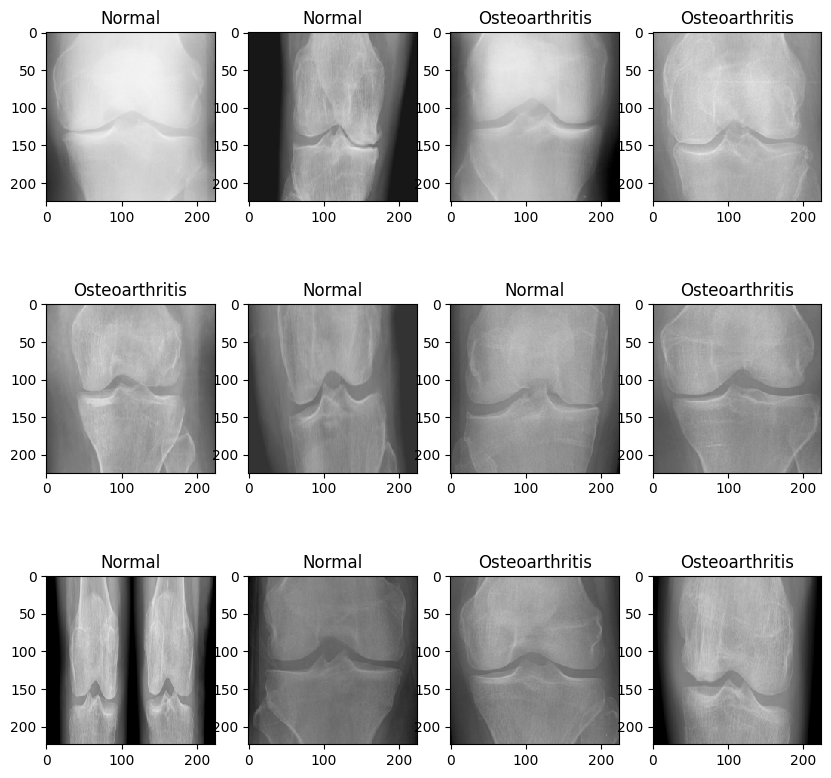

In [ ]:
# # Display first 15 images of moles, and how they are classified
# # Here IDC (+) means Benign
# # IDC (-) means Malignant
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Osteoarthritis')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        # zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)



dennet   = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)

nas      = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)




# vgg      = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)(inputs)

219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
outputs = GlobalAveragePooling2D()(dennet)
# Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(nas)])
# outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(32,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_299 (B  (None, 1536)              6144      
 atchNormalization)                                              
                                                                 
 dense_2 (Dense)             (None, 32)                49184     
                                                           

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-17-9d9ad6683064>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
75/74 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.7082

75/74 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8311

74/74 [==============================] - 50s 658ms/step - loss: 0.4229 - accuracy: 0.8311 - val_loss: 0.8913 - val_accuracy: 0.7646 - lr: 1.0000e-04
Epoch 3/40
75/74 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.8775

74/74 [==============================] - 50s 671ms/step - loss: 0.3481 - accuracy: 0.8775 - val_loss: 0.5986 - val_accuracy: 0.8097 - lr: 1.0000e-04
Epoch 4/40
75/74 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8926

74/74 [==============================] - 52s 697ms/step - loss: 0.2990 - accuracy: 0.8926 - val_loss: 0.8789 - val_accuracy: 0.8147 - lr: 1.0000e-04
Epoch 5/40
75/74 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.9018

74/74 [==============================] - 50s 658ms/step - loss: 0.2879 - accuracy: 0.9018 - val_loss: 0.2862 - val_accuracy: 0.9165 - lr: 1.0000e-04
Epoch 6/40
75/74 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9089

74/74 [==============================] - 51s 683ms/step - loss: 0.2524 - accuracy: 0.9089 - val_loss: 0.4841 - val_accuracy: 0.9015 - lr: 1.0000e-04
Epoch 7/40
75/74 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.9147

74/74 [==============================] - 52s 696ms/step - loss: 0.2574 - accuracy: 0.9147 - val_loss: 0.3945 - val_accuracy: 0.9082 - lr: 1.0000e-04
Epoch 8/40
75/74 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9252

74/74 [==============================] - 52s 691ms/step - loss: 0.2111 - accuracy: 0.9252 - val_loss: 0.3276 - val_accuracy: 0.9249 - lr: 1.0000e-04
Epoch 9/40
75/74 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9227

74/74 [==============================] - 51s 683ms/step - loss: 0.2220 - accuracy: 0.9227 - val_loss: 0.3041 - val_accuracy: 0.9316 - lr: 1.0000e-04
Epoch 10/40
75/74 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9239

74/74 [==============================] - 49s 647ms/step - loss: 0.2092 - accuracy: 0.9239 - val_loss: 0.2116 - val_accuracy: 0.9366 - lr: 1.0000e-04
Epoch 11/40
75/74 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9352

74/74 [==============================] - 53s 709ms/step - loss: 0.1992 - accuracy: 0.9352 - val_loss: 0.2141 - val_accuracy: 0.9499 - lr: 1.0000e-04
Epoch 12/40
75/74 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9344

74/74 [==============================] - 49s 652ms/step - loss: 0.2032 - accuracy: 0.9344 - val_loss: 0.3709 - val_accuracy: 0.9299 - lr: 1.0000e-04
Epoch 13/40
75/74 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9352

74/74 [==============================] - 54s 714ms/step - loss: 0.1812 - accuracy: 0.9352 - val_loss: 0.2592 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 14/40
75/74 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9302

74/74 [==============================] - 52s 687ms/step - loss: 0.1872 - accuracy: 0.9302 - val_loss: 0.2782 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 15/40
75/74 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.9448

74/74 [==============================] - 51s 680ms/step - loss: 0.1673 - accuracy: 0.9448 - val_loss: 0.2236 - val_accuracy: 0.9382 - lr: 1.0000e-04
Epoch 16/40
75/74 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9415

74/74 [==============================] - 52s 692ms/step - loss: 0.1724 - accuracy: 0.9415 - val_loss: 0.1807 - val_accuracy: 0.9499 - lr: 1.0000e-04
Epoch 17/40
75/74 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9373

74/74 [==============================] - 53s 695ms/step - loss: 0.1813 - accuracy: 0.9373 - val_loss: 0.3013 - val_accuracy: 0.9299 - lr: 1.0000e-04
Epoch 18/40
75/74 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9369

74/74 [==============================] - 51s 683ms/step - loss: 0.1832 - accuracy: 0.9369 - val_loss: 0.4593 - val_accuracy: 0.9165 - lr: 1.0000e-04
Epoch 19/40
75/74 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9406

74/74 [==============================] - 50s 664ms/step - loss: 0.1600 - accuracy: 0.9406 - val_loss: 0.1565 - val_accuracy: 0.9549 - lr: 1.0000e-04
Epoch 20/40
75/74 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9444

74/74 [==============================] - 52s 698ms/step - loss: 0.1514 - accuracy: 0.9444 - val_loss: 0.2023 - val_accuracy: 0.9482 - lr: 1.0000e-04
Epoch 21/40
75/74 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9511

74/74 [==============================] - 51s 681ms/step - loss: 0.1441 - accuracy: 0.9511 - val_loss: 0.2708 - val_accuracy: 0.9332 - lr: 1.0000e-04
Epoch 22/40
75/74 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9465

74/74 [==============================] - 51s 684ms/step - loss: 0.1464 - accuracy: 0.9465 - val_loss: 0.4190 - val_accuracy: 0.9366 - lr: 1.0000e-04
Epoch 23/40
75/74 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9448

74/74 [==============================] - 49s 651ms/step - loss: 0.1608 - accuracy: 0.9448 - val_loss: 0.1753 - val_accuracy: 0.9349 - lr: 1.0000e-04
Epoch 24/40
75/74 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.9469

74/74 [==============================] - 50s 658ms/step - loss: 0.1564 - accuracy: 0.9469 - val_loss: 0.2556 - val_accuracy: 0.9449 - lr: 1.0000e-04
Epoch 25/40
75/74 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9419

74/74 [==============================] - 52s 691ms/step - loss: 0.1483 - accuracy: 0.9419 - val_loss: 0.2233 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 26/40
75/74 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9553

74/74 [==============================] - 50s 667ms/step - loss: 0.1297 - accuracy: 0.9553 - val_loss: 0.3810 - val_accuracy: 0.9299 - lr: 1.0000e-04
Epoch 27/40
75/74 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9490

74/74 [==============================] - 52s 699ms/step - loss: 0.1398 - accuracy: 0.9490 - val_loss: 0.2516 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 28/40
75/74 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9582

74/74 [==============================] - 51s 679ms/step - loss: 0.1168 - accuracy: 0.9582 - val_loss: 0.1736 - val_accuracy: 0.9349 - lr: 1.0000e-04
Epoch 29/40
75/74 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9540

74/74 [==============================] - 51s 679ms/step - loss: 0.1260 - accuracy: 0.9540 - val_loss: 0.3296 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 30/40
75/74 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9561

74/74 [==============================] - 51s 683ms/step - loss: 0.1214 - accuracy: 0.9561 - val_loss: 0.2417 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 31/40
75/74 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9507

74/74 [==============================] - 51s 682ms/step - loss: 0.1479 - accuracy: 0.9507 - val_loss: 0.2557 - val_accuracy: 0.8998 - lr: 1.0000e-04
Epoch 32/40
75/74 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9532

74/74 [==============================] - 50s 656ms/step - loss: 0.1282 - accuracy: 0.9532 - val_loss: 0.1779 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 33/40
75/74 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9582

74/74 [==============================] - 51s 675ms/step - loss: 0.1188 - accuracy: 0.9582 - val_loss: 0.2320 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 34/40
75/74 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9507

74/74 [==============================] - 52s 693ms/step - loss: 0.1277 - accuracy: 0.9507 - val_loss: 0.1778 - val_accuracy: 0.9449 - lr: 1.0000e-04
Epoch 35/40
75/74 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9594

74/74 [==============================] - 51s 679ms/step - loss: 0.1182 - accuracy: 0.9594 - val_loss: 0.1682 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 36/40
75/74 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9674

74/74 [==============================] - 49s 659ms/step - loss: 0.0929 - accuracy: 0.9674 - val_loss: 0.1395 - val_accuracy: 0.9616 - lr: 1.0000e-04
Epoch 37/40
75/74 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9582

74/74 [==============================] - 52s 688ms/step - loss: 0.1149 - accuracy: 0.9582 - val_loss: 0.3341 - val_accuracy: 0.9249 - lr: 1.0000e-04
Epoch 38/40
75/74 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9640

74/74 [==============================] - 52s 690ms/step - loss: 0.0962 - accuracy: 0.9640 - val_loss: 0.2171 - val_accuracy: 0.9516 - lr: 1.0000e-04
Epoch 39/40
75/74 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9645

74/74 [==============================] - 51s 673ms/step - loss: 0.0990 - accuracy: 0.9645 - val_loss: 0.1582 - val_accuracy: 0.9633 - lr: 1.0000e-04
Epoch 40/40
75/74 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9611

74/74 [==============================] - 53s 706ms/step - loss: 0.1007 - accuracy: 0.9611 - val_loss: 0.1515 - val_accuracy: 0.9533 - lr: 1.0000e-04


19/19 [==============================] - 7s 157ms/step
Confusion matrix, without normalization
[[205  10]
 [ 18 366]]


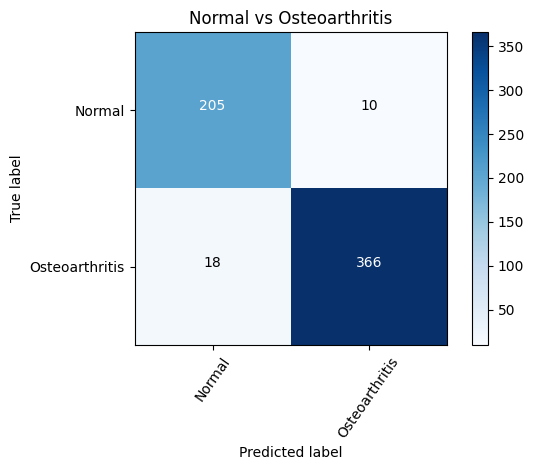

In [ ]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Osteoarthritis']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Osteoarthritis')

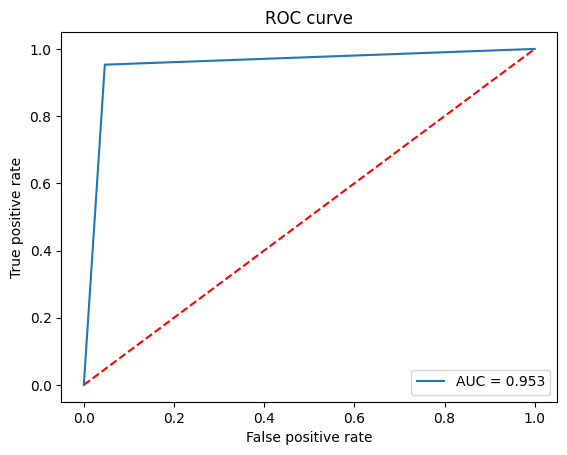

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

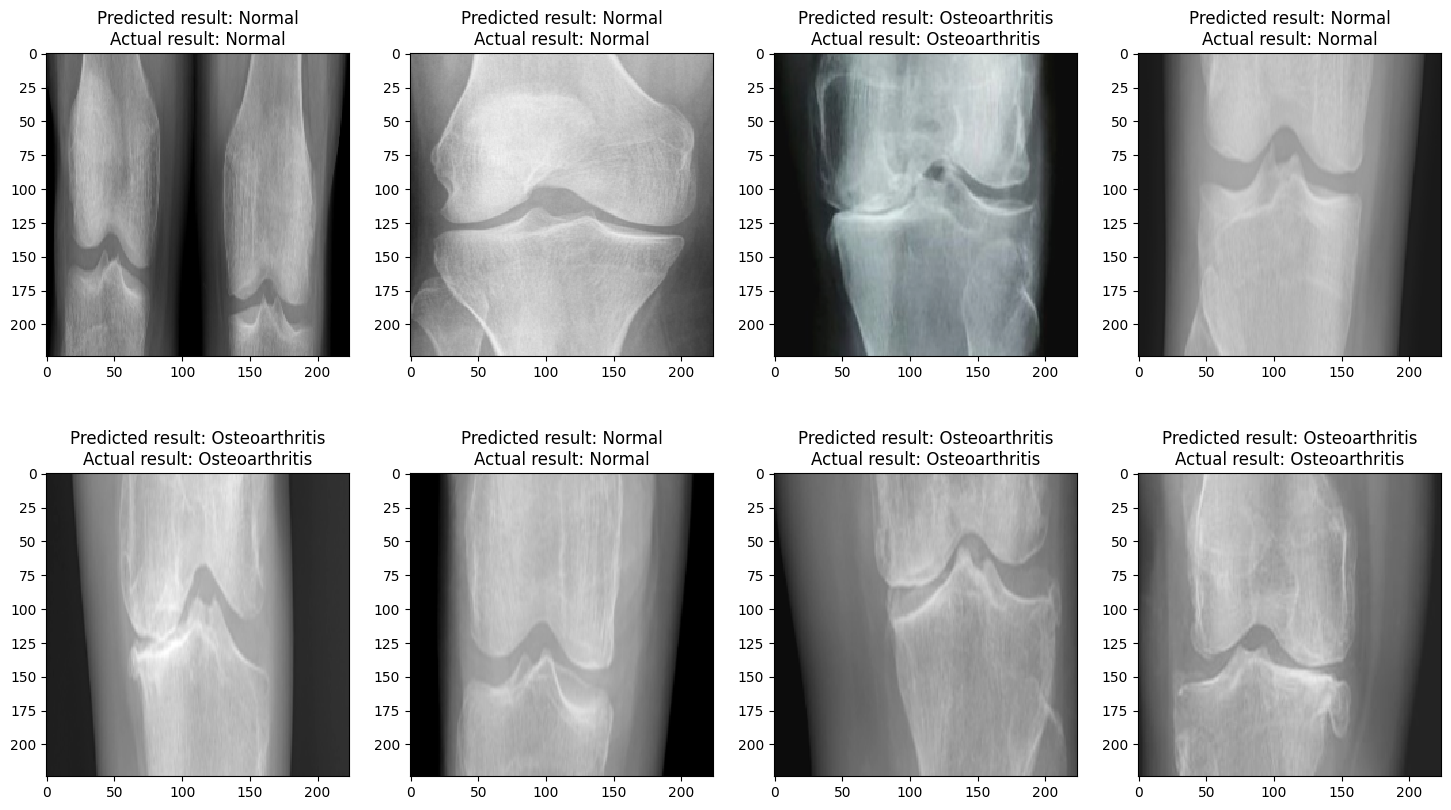

In [ ]:

i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Normal"
    else:
        return "Osteoarthritis"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result: "+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

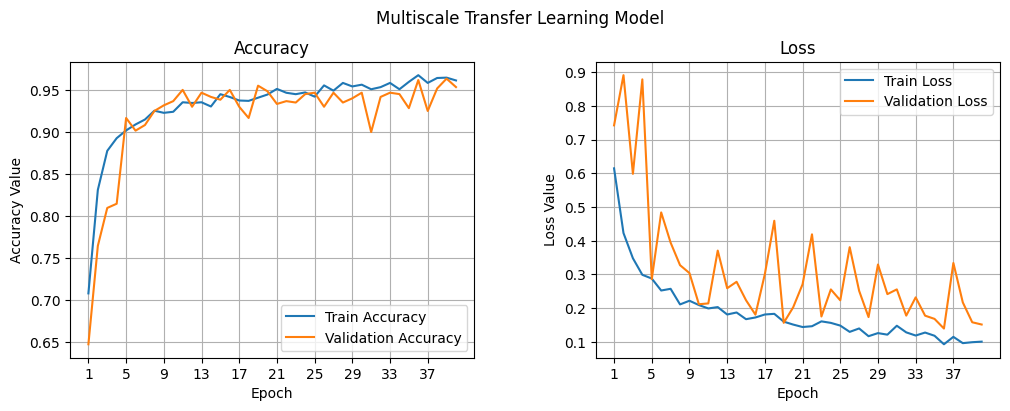

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

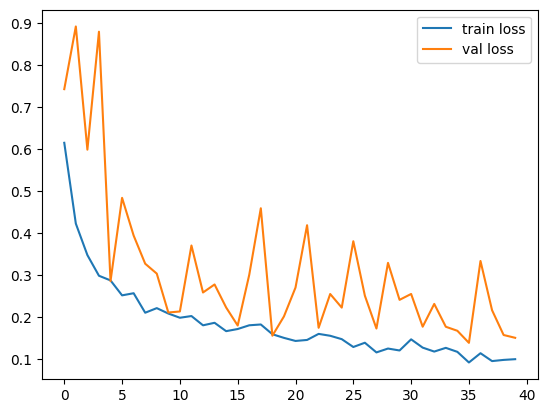

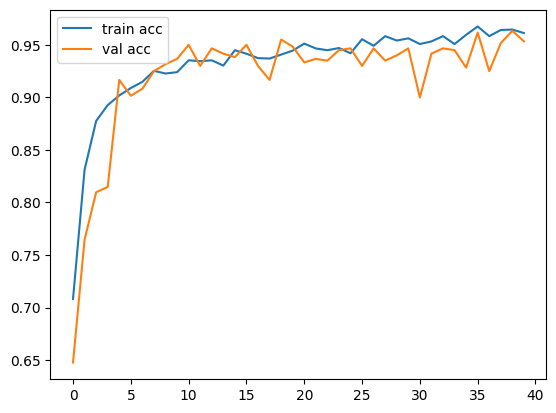

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

19/19 [==============================] - 3s 156ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Osteoarthritis', 'Normal']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
                precision    recall  f1-score   support

Osteoarthritis       0.92      0.95      0.94       215
        Normal       0.97      0.95      0.96       384

      accuracy                           0.95       599
     macro avg       0.95      0.95      0.95       599
  weighted avg       0.95      0.95      0.95       599

